In [68]:
from numpy import sin, cos, arccos, arcsin
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
import ffmpeg
from matplotlib.patches import Circle


In [69]:
class SinglePendulum:
    def __init__(self,
                init_state = [120,0],
                L = 2.0,
                M1 = 1.0,
                g = 9.81,
                b = 0.1,
                origin = (0,0)):
        self.init_state = np.asarray(init_state,dtype='float')
        self.params = (L,M1,g,b)
        self.origin = origin
        self.elapsed_time = 0 
        #Convert degrees to radians
        self.state = self.init_state * np.pi / 180.
        
        
    def position(self):
        (L, M1, g, b) = self.params
        
        x = np.cumsum([self.origin[0], L * sin(self.state[0])])
        y = np.cumsum([self.origin[1], -L * cos(self.state[0])])
        
        return (x,y)
    
    def energy(self):
        (L, M1, g,b) = self.params

        x = L * sin(self.state[0])
        y = -L * cos(self.state[0])
        
        vx = self.state[1] * y
        vy = -1 * self.state[1] * x
        
        v = [vx,vy]
        
        U = M1 * g * y
        K = 0.5 * M1 * np.dot(v,v)
        return U + K
    
    def equation(self, state, t):
        (L, M1, g, b) = self.params
        theta = state[0]
        omega = state[1]
        dydt = [omega, -b*omega -g/L * sin(theta)]
        return dydt
    
    def time_advance(self, dt):
        self.state = integrate.odeint(self.equation,self.state,[0, dt])[1]
        self.elapsed_time += dt


In [70]:
pendulum = SinglePendulum([-179,0])
dt = 1./30 # 30 fps
global l
l = pendulum.params[0]

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


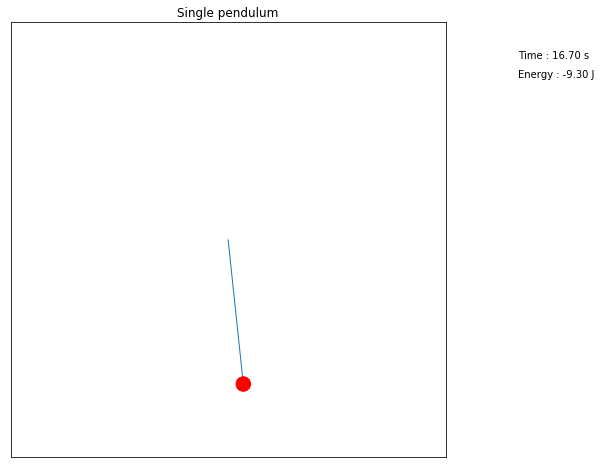

In [71]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-1.5*l, 1.5*l), ylim=(-1.5*l, 1.5*l))
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Single pendulum')


line, = ax.plot([],[], lw = 1)
time_txt = ax.text(4,2.5,'')
energy_txt = ax.text(4, 2.25,'')



def init():
    line.set_data([],[])
    time_txt.set_text('')
    energy_txt.set_text('')
    return line, time_txt, energy_txt

def animate(i):
    global pendulum, dt
    ax.patches = [] # Redraw patch
    pendulum.time_advance(dt) # Update new position of pendulum 
    line.set_data(*pendulum.position()) # Draw pendulum's position
    pos=pendulum.position()
    x=pos[0][-1]
    y=pos[1][-1]
    energy_txt.set_text('Energy : %.2f J' % pendulum.energy())
    time_txt.set_text('Time : %.2f s' % pendulum.elapsed_time)
    c1 = Circle((x,y), 0.1, fc='r', ec='r', zorder=10) 
    ax.add_patch(c1) # Draw pendulum ball 
    return line, energy_txt, time_txt
    

# Find optimal interval for animation by basing it on how long the animate function takes to run
from time import time
t0 = time()
animate(0)
t1 = time()
interval = 1000 * dt - (t1 - t0)
    
anim = animation.FuncAnimation(fig,animate,init_func = init, frames = 500, blit = True, interval = interval)

anim.save('single_pendulum_mine.gif', fps=30, extra_args=['-vcodec', 'libx264'])


plt.show()